#Load the Saved Model

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: 
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE 

Tensorflow version 2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
new_model_mn2 = tf.keras.models.load_model('/content/drive/MyDrive/dataset/mri_model_VGG16_Prostate.h5')

# Show the model architecture
new_model_mn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.5.0


In [ ]:
%cp /content/drive/MyDrive/dataset/benign_images_mri.zip /tmp
%cp /content/drive/MyDrive/dataset/malignant_images_mri.zip /tmp

In [ ]:
%mkdir /tmp/Prostate
!unzip /tmp/benign_images_mri.zip -d /tmp/Prostate
!unzip /tmp/malignant_images_mri.zip -d /tmp/Prostate

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4059.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_406.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4060.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4061.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4062.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4063.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4064.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4065.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4066.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4067.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4068.PNG  
  inflating: /tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_4069.PNG  
  

# Read and pre-process image

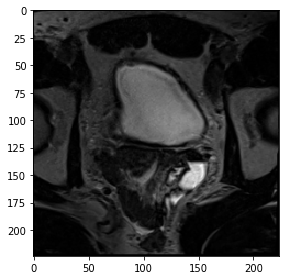

In [ ]:
#Xi = skimage.io.imread("/tmp/Prostate/malignant_images_mri/PROSTATE_CANCER_MALIGNANT_1002.PNG")
Xi = skimage.io.imread("/tmp/Prostate/benign_images_mri/PROSTATE_CANCER_BENIGN_1019.PNG")
Xi = skimage.transform.resize(Xi, (224,224)) 
Xi = (Xi - 0.5)*2 
skimage.io.imshow(Xi/2+0.5) #

In [ ]:
np.random.seed(222)
preds = new_model_mn2.predict(Xi[np.newaxis,:,:,:])
print(preds)

[[0.58810174 0.41189823]]


In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes   

array([0, 1])

#Step 1: Create perturbations of image

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

37

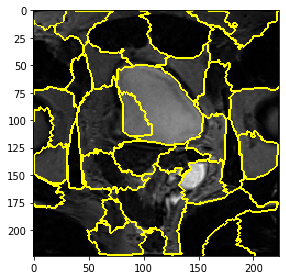

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

# Create random perturbations

In [ ]:
#num_perturb = 150
num_perturb = 224
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

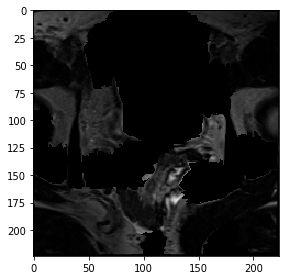

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

# Step 2: Use ML classifier to predict classes of new generated images

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = new_model_mn2.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(224, 1, 2)

#Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(224,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(224,)

# Step 4: Use perturbations, predictions and weights to fit an explainable (linear) model

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.05635121,  0.09070299,  0.02261282,  0.01305797,  0.02955856,
        0.00317633,  0.08588111, -0.06586753,  0.07175391,  0.04411556,
        0.008664  ,  0.06989623, -0.10973836,  0.20939792, -0.1432419 ,
        0.03780509,  0.01974951,  0.0508178 ,  0.15547919, -0.04432146,
        0.04008313, -0.05983217, -0.01066917, -0.05943143,  0.05686299,
       -0.06371827, -0.02842245, -0.01377921,  0.10409817,  0.10217675,
       -0.0268427 , -0.02338326,  0.2268657 ,  0.04239159,  0.0845926 ,
       -0.02184657,  0.03424431])

# Compute top features (superpixels)

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([28, 18, 13, 32])

# Show LIME explanation (image with top features)

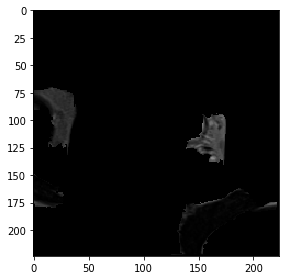

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )